In [1]:
from lightgbm import LGBMRegressor

import optuna
from optuna.visualization.matplotlib import plot_param_importances
from optuna.visualization import plot_optimization_history

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, \
    mean_squared_log_error

from catboost import CatBoostRegressor
import shap

import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression

import warnings

warnings.filterwarnings("ignore")

RAND = 10
N_FOLDS = 3

In [2]:
def r2_adjusted(y_true: np.ndarray, y_pred: np.ndarray,
                X_test: np.ndarray) -> float:
    """Коэффициент детерминации (множественная регрессия)"""
    N_objects = len(y_true)
    N_features = X_test.shape[1]
    r2 = r2_score(y_true, y_pred)
    return 1 - (1 - r2) * (N_objects - 1) / (N_objects - N_features - 1)


def mpe(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Mean percentage error"""
    return np.mean((y_true - y_pred) / y_true) * 100


def mape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Mean absolute percentage error"""
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100


def wape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Weighted Absolute Percent Error"""
    return np.sum(np.abs(y_pred - y_true)) / np.sum(y_true) * 100


def rmsle(y_true: np.ndarray, y_pred: np.ndarray) -> np.float64:
    """
    The Root Mean Squared Log Error (RMSLE) metric 
    Логаритмическая ошибка средней квадратичной ошибки
    """
    try:
        return np.sqrt(mean_squared_log_error(y_true, y_pred))
    except:
        return None


def get_metrics(y_test: np.ndarray,
                y_pred: np.ndarray,
                X_test: np.ndarray,
                name: str = None):
    """Генерация таблицы с метриками"""
    df_metrics = pd.DataFrame()

    df_metrics['model'] = [name]

    df_metrics['MAE'] = mean_absolute_error(y_test, y_pred)
    df_metrics['MSE'] = mean_squared_error(y_test, y_pred)
    df_metrics['RMSE'] = np.sqrt(mean_squared_error(y_test, y_pred))
    df_metrics['RMSLE'] = rmsle(y_test, y_pred)
    df_metrics['R2 adjusted'] = r2_adjusted(y_test, y_pred, X_test)
    df_metrics['MPE_%'] = mpe(y_test, y_pred)
    df_metrics['MAPE_%'] = mape(y_test, y_pred)
    df_metrics['WAPE_%'] = wape(y_test, y_pred)

    return df_metrics


def check_overfitting(model, X_train, y_train, X_test, y_test, metric_fun):
    """
    Проверка на overfitting
    """
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    mae_train = metric_fun(y_train, y_pred_train)
    mae_test = metric_fun(y_test, y_pred_test)

    print(f'{metric_fun.__name__} train: %.3f' % mae_train)
    print(f'{metric_fun.__name__} test: %.3f' % mae_test)
    print(f'delta = {(abs(mae_train - mae_test)/mae_train*100):.1f} %')

# Загрузка данных

- df - информация об автомобилях 
    - num - номер региона
    - brand - бренд
    - model - модель авто
    - year - год выпуска
    - description - краткое описание
    - location - локация
    - price - цена
    
- salary - средняя ЗП в России за 2022 год по регионам
    - num - номер региона
    - region - название региона
    - mean_salary - средняя ЗП (медиана)

In [3]:
df = pd.read_csv('data/clean_full_dataset.csv')
df = df[df.flg_new_auto == 0]

In [4]:
df[:4]

,num,brand,model,year,price,region,median_salary,Region_en,NAME_1,flg_more_avg_salary,age,liters,horse_power,type_engine,transmission,machine_drive,mileage,flg_new_auto,body_type
0,1,Mercedes-Benz,E-Class,2006,830000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,16,3.2,204.0,дизель,автомат,задний,350.0,0,Седан
1,1,Mercedes-Benz,E-Class,1999,280000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,23,2.8,193.0,бензин,автомат,задний,360.0,0,Седан
2,1,Mercedes-Benz,E-Class,1991,200000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,31,3.0,220.0,бензин,автомат,задний,352.0,0,Седан
3,1,Mercedes-Benz,C-Class,2011,900000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,11,1.8,156.0,бензин,автомат,задний,134.0,0,Седан


## Modeling

In [5]:
cols_drop = [
    'brand', 'num', 'year', 'median_salary', 'Region_en', 'NAME_1',
    'flg_more_avg_salary', 'flg_new_auto'
]
df = df.drop(cols_drop, axis=1)

cols_cat = df.select_dtypes('object').columns
df[cols_cat] = df[cols_cat].astype('category')

In [6]:
df[:4]

,model,price,region,age,liters,horse_power,type_engine,transmission,machine_drive,mileage,body_type
0,E-Class,830000,Республика Адыгея,16,3.2,204.0,дизель,автомат,задний,350.0,Седан
1,E-Class,280000,Республика Адыгея,23,2.8,193.0,бензин,автомат,задний,360.0,Седан
2,E-Class,200000,Республика Адыгея,31,3.0,220.0,бензин,автомат,задний,352.0,Седан
3,C-Class,900000,Республика Адыгея,11,1.8,156.0,бензин,автомат,задний,134.0,Седан


In [7]:
X = df.drop(['price'], axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    shuffle=True,
                                                    random_state=RAND)

X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.16,
                                                    random_state=RAND)

eval_set = [(X_val, y_val)]

### Baseline

In [8]:
from sklearn.compose import ColumnTransformer


transformers_list = [
    ('encode', OneHotEncoder(dtype='int', drop='first'), [
        'region', 'model', 'region', 'type_engine', 'transmission',
        'machine_drive', 'body_type'
    ]),
    ('scale', StandardScaler(),
     ['age', 'liters', 'horse_power', 'mileage'])
]

column_transformer = ColumnTransformer(transformers_list)

In [9]:
pipe = Pipeline([('columnTransformer', column_transformer),
                 ('lr', LinearRegression())])
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

In [10]:
metrics = get_metrics(y_test, y_pred, X_test, 'LinearRegression_baseline')
metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,LinearRegression_baseline,799212.557098,1.724634e+12,1.313253e+06,None,0.74152,17.192909,74.736496,34.202426


In [11]:
check_overfitting(pipe,
                  X_train,
                  y_train,
                  X_test,
                  y_test,
                  metric_fun=mean_absolute_error)

mean_absolute_error train: 807728.960
mean_absolute_error test: 799212.557
delta = 1.1 %


#### LGBMRegressor

In [12]:
lgb = LGBMRegressor(random_state=RAND, objective='mae')
lgb.fit(X_train_,
        y_train_,
        eval_metric="mae",
        eval_set=eval_set,
        verbose=False,
        early_stopping_rounds=100)

y_pred = lgb.predict(X_test)

In [13]:
metrics = metrics.append(
    get_metrics(y_test, y_pred, X_test, 'LGBMRegressor_baseline'))
metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,LinearRegression_baseline,799212.557098,1.724634e+12,1.313253e+06,NaN,0.741520,17.192909,74.736496,34.202426
0,LGBMRegressor_baseline,288587.249104,3.886503e+11,6.234182e+05,0.242411,0.941751,-3.810651,16.634980,12.350136


In [14]:
check_overfitting(lgb,
                  X_train,
                  y_train,
                  X_test,
                  y_test,
                  metric_fun=mean_absolute_error)

mean_absolute_error train: 265661.313
mean_absolute_error test: 288587.249
delta = 8.6 %


#### CatBoostRegressor

In [15]:
cat_features = X_val.select_dtypes('category').columns.tolist()

cb = CatBoostRegressor(random_seed=RAND,
                       loss_function='MAE',
                       eval_metric='MAE',
                       cat_features=cat_features,
                       allow_writing_files=False)

eval_set = [(X_val, y_val)]

cb.fit(X_train_,
       y_train_,
       eval_set=eval_set,
       verbose=0,
       early_stopping_rounds=100)

y_pred_cb = cb.predict(X_test)

In [16]:
metrics = metrics.append(
    get_metrics(y_test, y_pred_cb, X_test, 'CatBoostRegressor_baseline'))
metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,LinearRegression_baseline,799212.557098,1.724634e+12,1.313253e+06,NaN,0.741520,17.192909,74.736496,34.202426
0,LGBMRegressor_baseline,288587.249104,3.886503e+11,6.234182e+05,0.242411,0.941751,-3.810651,16.634980,12.350136
0,CatBoostRegressor_baseline,297014.220161,4.017200e+11,6.338139e+05,0.245185,0.939792,-3.759254,16.964674,12.710770


In [17]:
check_overfitting(cb,
                  X_train,
                  y_train,
                  X_test,
                  y_test,
                  metric_fun=mean_absolute_error)

mean_absolute_error train: 280316.659
mean_absolute_error test: 297014.220
delta = 6.0 %


In [18]:
metrics.set_index('model').round(3)

,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
model,,,,,,,,
LinearRegression_baseline,799212.557,1.724634e+12,1313253.063,NaN,0.742,17.193,74.736,34.202
LGBMRegressor_baseline,288587.249,3.886503e+11,623418.212,0.242,0.942,-3.811,16.635,12.350
CatBoostRegressor_baseline,297014.220,4.017200e+11,633813.862,0.245,0.940,-3.759,16.965,12.711


### Tuning
#### LGBMRegressor

In [19]:
# целевая функция
def objective_lgb(trial, X, y, N_FOLDS, random_state):
    lgb_params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [300]),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3, log=True),
        # num_leaves - кол-во листьев для принятия решений в одном дереве
        "num_leaves": trial.suggest_int("num_leaves", 20, 150, step=1),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        # min_data_in_leaf - минимальное количество объектов, которые должны 
        # попасть в узел для его добавления
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 1000),
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-3, 100),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-3, 100),
        "min_gain_to_split": trial.suggest_int("min_gain_to_split", 0, 15),
        # feature_fraction - процент признаков для выборки при обучении каждого дерева 
        "feature_fraction": trial.suggest_float("feature_fraction", 0.7, 1.0),  
        "objective": trial.suggest_categorical("objective", ['mae']),
        "random_state": trial.suggest_categorical("random_state", [random_state]),        
    }

    cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=random_state)

    cv_predicts = np.empty(N_FOLDS)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        model = LGBMRegressor(**lgb_params)
        model.fit(X_train,
                  y_train,
                  eval_set=[(X_test, y_test)],
                  eval_metric="mae",
                  early_stopping_rounds=100,
                  verbose=0)
        
        preds = model.predict(X_test)
        cv_predicts[idx] = mean_absolute_error(y_test, preds)

    return np.mean(cv_predicts)

In [20]:
study = optuna.create_study(direction="minimize", study_name="LGB_21")


def func(trial):
    return objective_lgb(trial,
                         X_train,
                         y_train,
                         N_FOLDS=N_FOLDS,
                         random_state=RAND)

optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(func, n_trials=15, show_progress_bar=True)

[I 2022-12-30 14:05:50,316] A new study created in memory with name: LGB_21


  0%|          | 0/15 [00:00<?, ?it/s]

[LightGBM] [Warning] lambda_l1 is set=5.599940131019438, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.599940131019438
[LightGBM] [Warning] min_gain_to_split is set=5, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5
[LightGBM] [Warning] min_data_in_leaf is set=584, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=584
[LightGBM] [Warning] lambda_l2 is set=2.781800109837094, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.781800109837094
[LightGBM] [Warning] feature_fraction is set=0.966541161004983, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.966541161004983
[LightGBM] [Warning] lambda_l1 is set=5.599940131019438, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.599940131019438
[LightGBM] [Warning] min_gain_to_split is set=5, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5
[LightGBM] [Warning] min_data_in_leaf is set=584, min_child_samples=20 will be ignored. Cu

[LightGBM] [Warning] lambda_l1 is set=0.21933339059958581, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21933339059958581
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_data_in_leaf is set=241, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=241
[LightGBM] [Warning] lambda_l2 is set=0.004097115431691188, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004097115431691188
[LightGBM] [Warning] feature_fraction is set=0.943957627179565, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.943957627179565
[LightGBM] [Warning] lambda_l1 is set=0.21933339059958581, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21933339059958581
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_data_in_leaf is set=241, min_child_samples=20 will 

[LightGBM] [Warning] lambda_l1 is set=32.305658054177385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=32.305658054177385
[LightGBM] [Warning] min_gain_to_split is set=3, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3
[LightGBM] [Warning] min_data_in_leaf is set=153, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=153
[LightGBM] [Warning] lambda_l2 is set=0.0043921246810641355, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0043921246810641355
[LightGBM] [Warning] feature_fraction is set=0.968227549238351, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.968227549238351
[LightGBM] [Warning] lambda_l1 is set=4.003596501590702, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.003596501590702
[LightGBM] [Warning] min_gain_to_split is set=8, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8
[LightGBM] [Warning] min_data_in_leaf is set=638, min_child_samples=20 will be i

[LightGBM] [Warning] lambda_l1 is set=1.3996442526250699, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3996442526250699
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] lambda_l2 is set=12.692765434363503, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.692765434363503
[LightGBM] [Warning] feature_fraction is set=0.8995243472198571, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8995243472198571
[LightGBM] [Warning] lambda_l1 is set=1.3996442526250699, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3996442526250699
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignore

In [21]:
study.best_params

{'n_estimators': 300,
 'learning_rate': 0.24733210890431104,
 'num_leaves': 30,
 'max_depth': 12,
 'min_data_in_leaf': 10,
 'lambda_l1': 1.3996442526250699,
 'lambda_l2': 12.692765434363503,
 'min_gain_to_split': 0,
 'feature_fraction': 0.8995243472198571,
 'objective': 'mae',
 'random_state': 10}

<AxesSubplot:title={'center':'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

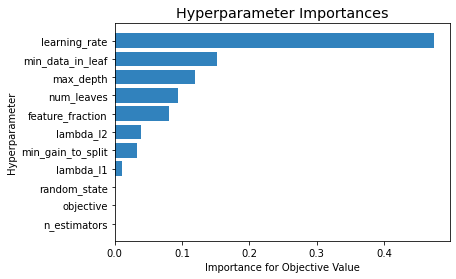

In [22]:
plot_param_importances(study)

In [23]:
best_params_ver1 = study.best_params
lgb_optuna = LGBMRegressor(**best_params_ver1)
lgb_optuna.fit(X_train_,
               y_train_,
               eval_metric="mae",
               eval_set=eval_set,
               verbose=False,
               early_stopping_rounds=100)

y_pred = lgb_optuna.predict(X_test)

metrics = metrics.append(
    get_metrics(y_test=y_test,
                y_pred=y_pred,
                X_test=X_test,
                name='LGBoost_Optuna'))

round(metrics.set_index('model'), 3)

[LightGBM] [Warning] lambda_l1 is set=1.3996442526250699, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3996442526250699
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] lambda_l2 is set=12.692765434363503, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.692765434363503
[LightGBM] [Warning] feature_fraction is set=0.8995243472198571, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8995243472198571


,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
model,,,,,,,,
LinearRegression_baseline,799212.557,1.724634e+12,1313253.063,NaN,0.742,17.193,74.736,34.202
LGBMRegressor_baseline,288587.249,3.886503e+11,623418.212,0.242,0.942,-3.811,16.635,12.350
CatBoostRegressor_baseline,297014.220,4.017200e+11,633813.862,0.245,0.940,-3.759,16.965,12.711
LGBoost_Optuna,276632.583,3.419831e+11,584793.179,NaN,0.949,-3.717,16.055,11.839


In [24]:
check_overfitting(lgb_optuna,
                  X_train,
                  y_train,
                  X_test,
                  y_test,
                  metric_fun=mean_absolute_error)

mean_absolute_error train: 224874.458
mean_absolute_error test: 276632.583
delta = 23.0 %


In [25]:
study.optimize(func, n_trials=25, show_progress_bar=True)

  0%|          | 0/25 [00:00<?, ?it/s]

[LightGBM] [Warning] lambda_l1 is set=0.03685627845228447, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03685627845228447
[LightGBM] [Warning] min_gain_to_split is set=2, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2
[LightGBM] [Warning] min_data_in_leaf is set=341, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=341
[LightGBM] [Warning] lambda_l2 is set=15.107920993539443, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.107920993539443
[LightGBM] [Warning] feature_fraction is set=0.8207219692421607, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8207219692421607
[LightGBM] [Warning] lambda_l1 is set=0.03685627845228447, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03685627845228447
[LightGBM] [Warning] min_gain_to_split is set=2, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2
[LightGBM] [Warning] min_data_in_leaf is set=341, min_child_samples=20 will be

[LightGBM] [Warning] lambda_l1 is set=4.558013781040221, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.558013781040221
[LightGBM] [Warning] min_gain_to_split is set=15, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=15
[LightGBM] [Warning] min_data_in_leaf is set=746, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=746
[LightGBM] [Warning] lambda_l2 is set=2.428785864262282, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.428785864262282
[LightGBM] [Warning] feature_fraction is set=0.920767496935414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.920767496935414
[LightGBM] [Warning] lambda_l1 is set=4.558013781040221, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.558013781040221
[LightGBM] [Warning] min_gain_to_split is set=15, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=15
[LightGBM] [Warning] min_data_in_leaf is set=746, min_child_samples=20 will be ignored

[LightGBM] [Warning] lambda_l1 is set=0.6787638877231635, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6787638877231635
[LightGBM] [Warning] min_gain_to_split is set=1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1
[LightGBM] [Warning] min_data_in_leaf is set=115, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=115
[LightGBM] [Warning] lambda_l2 is set=0.49532019405633776, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.49532019405633776
[LightGBM] [Warning] feature_fraction is set=0.8816530913749066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8816530913749066
[LightGBM] [Warning] lambda_l1 is set=9.732964787723615, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.732964787723615
[LightGBM] [Warning] min_gain_to_split is set=5, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5
[LightGBM] [Warning] min_data_in_leaf is set=252, min_child_samples=20 will be ign

[LightGBM] [Warning] lambda_l1 is set=0.016453942650958817, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.016453942650958817
[LightGBM] [Warning] min_gain_to_split is set=4, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4
[LightGBM] [Warning] min_data_in_leaf is set=289, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=289
[LightGBM] [Warning] lambda_l2 is set=41.46692145299437, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.46692145299437
[LightGBM] [Warning] feature_fraction is set=0.8138315474043165, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8138315474043165
[LightGBM] [Warning] lambda_l1 is set=0.016453942650958817, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.016453942650958817
[LightGBM] [Warning] min_gain_to_split is set=4, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4
[LightGBM] [Warning] min_data_in_leaf is set=289, min_child_samples=20 will 

[LightGBM] [Warning] lambda_l1 is set=3.2434563847293267, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2434563847293267
[LightGBM] [Warning] min_gain_to_split is set=2, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] lambda_l2 is set=0.029868905180733096, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.029868905180733096
[LightGBM] [Warning] feature_fraction is set=0.933586195241099, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.933586195241099
[LightGBM] [Warning] lambda_l1 is set=3.2434563847293267, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2434563847293267
[LightGBM] [Warning] min_gain_to_split is set=2, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be igno

[LightGBM] [Warning] lambda_l1 is set=0.9782340964593069, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9782340964593069
[LightGBM] [Warning] min_gain_to_split is set=11, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11
[LightGBM] [Warning] min_data_in_leaf is set=332, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=332
[LightGBM] [Warning] lambda_l2 is set=10.566355657380779, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.566355657380779
[LightGBM] [Warning] feature_fraction is set=0.9092654801451193, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9092654801451193
[LightGBM] [Warning] lambda_l1 is set=11.033618223701245, reg_alpha=0.0 will be ignored. Current value: lambda_l1=11.033618223701245
[LightGBM] [Warning] min_gain_to_split is set=1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1
[LightGBM] [Warning] min_data_in_leaf is set=156, min_child_samples=20 will be i

In [26]:
best_params_ver2 = study.best_params
lgb_optuna = LGBMRegressor(**best_params_ver2)
lgb_optuna.fit(X_train_,
               y_train_,
               eval_metric="mae",
               eval_set=eval_set,
               verbose=False,
               early_stopping_rounds=100)

y_pred = lgb_optuna.predict(X_test)

metrics = metrics.append(
    get_metrics(y_test=y_test,
                y_pred=y_pred,
                X_test=X_test,
                name='LGBoost_Optuna_ver2'))

round(metrics.set_index('model'), 3)

[LightGBM] [Warning] lambda_l1 is set=1.3996442526250699, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3996442526250699
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] lambda_l2 is set=12.692765434363503, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.692765434363503
[LightGBM] [Warning] feature_fraction is set=0.8995243472198571, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8995243472198571


,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
model,,,,,,,,
LinearRegression_baseline,799212.557,1.724634e+12,1313253.063,NaN,0.742,17.193,74.736,34.202
LGBMRegressor_baseline,288587.249,3.886503e+11,623418.212,0.242,0.942,-3.811,16.635,12.350
CatBoostRegressor_baseline,297014.220,4.017200e+11,633813.862,0.245,0.940,-3.759,16.965,12.711
LGBoost_Optuna,276632.583,3.419831e+11,584793.179,NaN,0.949,-3.717,16.055,11.839
LGBoost_Optuna_ver2,276632.583,3.419831e+11,584793.179,NaN,0.949,-3.717,16.055,11.839


In [27]:
check_overfitting(lgb_optuna,
                  X_train,
                  y_train,
                  X_test,
                  y_test,
                  metric_fun=mean_absolute_error)

mean_absolute_error train: 224874.458
mean_absolute_error test: 276632.583
delta = 23.0 %


#### CatBoostRegressor

In [28]:
from catboost import Pool


cat_feat = X_train.select_dtypes('category').columns.tolist()

# целевая функция
def objective_cat(trial, X, y, N_FOLDS, random_state, cat_feat):
    params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [300]),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3, log=True), #0.07
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        #"l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 1e-5, 1e2),        
        #"bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS", "No"]),
        #'grow_policy': trial.suggest_categorical('grow_policy', ["SymmetricTree", "Depthwise", "Lossguide"]),
        
        "use_best_model": trial.suggest_categorical("use_best_model", [True]),
        'loss_function': trial.suggest_categorical("loss_function", ['MAE']),
        "eval_metric": trial.suggest_categorical("eval_metric", ['MAE']),
        "random_state": trial.suggest_categorical("random_state", [random_state]),
        "allow_writing_files": trial.suggest_categorical("allow_writing_files", [False])
    }
    
    #if params["bootstrap_type"] == "Bayesian":
    #    params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    #elif params["bootstrap_type"] == "Bernoulli":
    #    params["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

    cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=random_state)

    cv_predicts = np.empty(N_FOLDS)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        train_data = Pool(data=X_train, label=y_train, cat_features=cat_feat)
        eval_data = Pool(data=X_test, label=y_test, cat_features=cat_feat)
        
        model = CatBoostRegressor(**params)
        model.fit(train_data,
                  eval_set=eval_data,
                  early_stopping_rounds=100,
                  verbose=0)

        preds = model.predict(X_test)
        cv_predicts[idx] = mean_absolute_error(y_test, preds)

    return np.mean(cv_predicts)

In [29]:
study_cat = optuna.create_study(direction="minimize", study_name="Cat_02")


def func_cat(trial):
    return objective_cat(trial,
                         X_train,
                         y_train,
                         N_FOLDS=N_FOLDS,
                         random_state=RAND,
                         cat_feat=cat_feat)


study_cat.optimize(func_cat, n_trials=3, show_progress_bar=True)

  0%|          | 0/3 [00:00<?, ?it/s]

In [30]:
study_cat.best_params

{'n_estimators': 300,
 'learning_rate': 0.10124448597112595,
 'max_depth': 5,
 'use_best_model': True,
 'loss_function': 'MAE',
 'eval_metric': 'MAE',
 'random_state': 10,
 'allow_writing_files': False}

In [31]:
cat_optuna = CatBoostRegressor(**study_cat.best_params)
cat_optuna.fit(X_train_,
               y_train_,
               cat_features=cat_features,
               eval_set=eval_set,
               verbose=False,
               early_stopping_rounds=100)

y_pred = cat_optuna.predict(X_test)

metrics = metrics.append(
    get_metrics(y_test=y_test,
                y_pred=y_pred,
                X_test=X_test,
                name='CatBoostRegressor_Optuna'))

round(metrics.set_index('model'), 3)

,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
model,,,,,,,,
LinearRegression_baseline,799212.557,1.724634e+12,1313253.063,NaN,0.742,17.193,74.736,34.202
LGBMRegressor_baseline,288587.249,3.886503e+11,623418.212,0.242,0.942,-3.811,16.635,12.350
CatBoostRegressor_baseline,297014.220,4.017200e+11,633813.862,0.245,0.940,-3.759,16.965,12.711
LGBoost_Optuna,276632.583,3.419831e+11,584793.179,NaN,0.949,-3.717,16.055,11.839
LGBoost_Optuna_ver2,276632.583,3.419831e+11,584793.179,NaN,0.949,-3.717,16.055,11.839
CatBoostRegressor_Optuna,311356.946,4.313140e+11,656745.018,0.250,0.935,-3.770,17.452,13.325


In [32]:
check_overfitting(cat_optuna,
                  X_train,
                  y_train,
                  X_test,
                  y_test,
                  metric_fun=mean_absolute_error)

mean_absolute_error train: 297164.643
mean_absolute_error test: 311356.946
delta = 4.8 %


## Feature importance

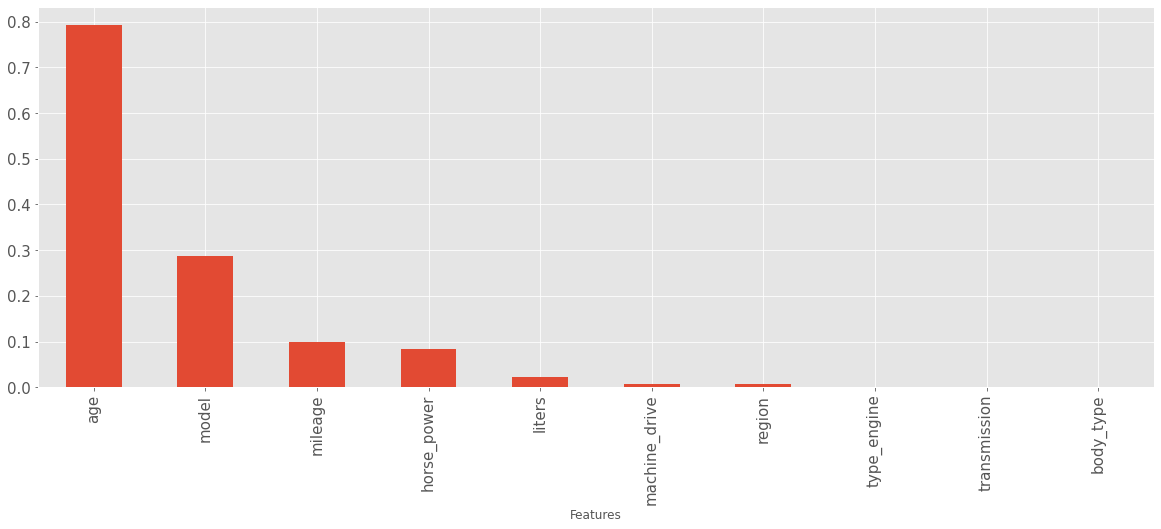

In [33]:
from sklearn.inspection import permutation_importance


r = permutation_importance(lgb_optuna, X_test, y_test, n_repeats=10)

perm_df = pd.DataFrame((r['importances_mean'], X_train.columns.to_list()),
                       index=('Score', 'Features'))

perm_df = perm_df.T.sort_values(ascending=False, by='Score')
perm_df.set_index('Features')['Score'].plot.bar(figsize=(20, 7), grid=True)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

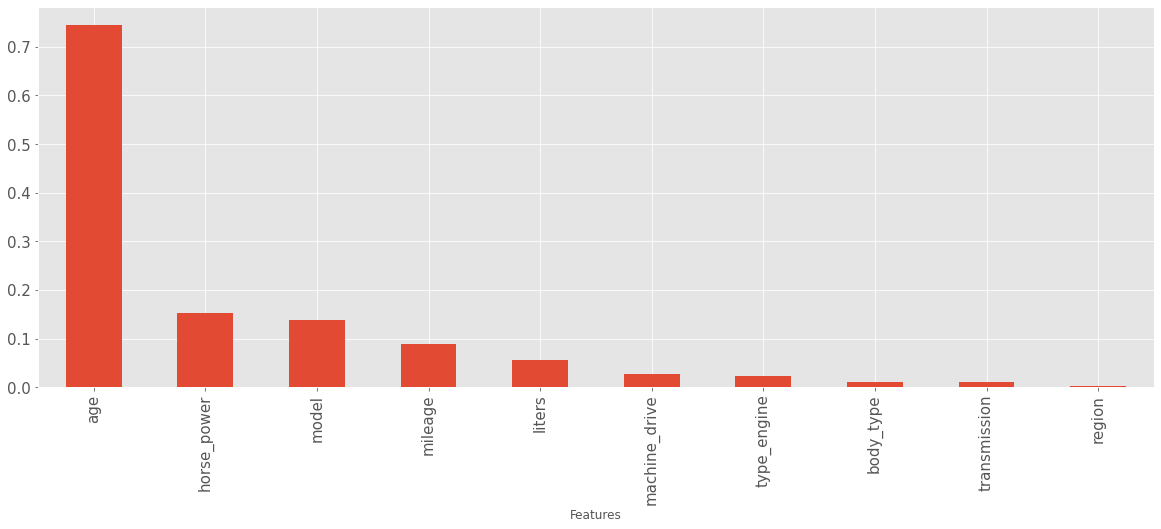

In [35]:
r = permutation_importance(cat_optuna, X_test, y_test, n_repeats=10)

perm_df = pd.DataFrame((r['importances_mean'], X_train.columns.to_list()),
                       index=('Score', 'Features'))

perm_df = perm_df.T.sort_values(ascending=False, by='Score')
perm_df.set_index('Features')['Score'].plot.bar(figsize=(20, 7), grid=True)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()